In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
data = torch.from_numpy(df.values).float()
data.shape

torch.Size([569, 31])

In [4]:
Y = data[:,-1:]
X = data[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([398, 30]) torch.Size([398, 1])
torch.Size([85, 30]) torch.Size([85, 1])
torch.Size([86, 30]) torch.Size([86, 1])


In [13]:
n_epochs = 3000
print_interval = 100
early_stop = 100

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [8]:
batch_size = 64

train_loader = DataLoader(
    dataset=CustomDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True, # Allow shuffling only for training set.
)
valid_loader = DataLoader(
    dataset=CustomDataset(X_valid, y_valid),
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=CustomDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=False,
)

print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset),
    len(valid_loader.dataset),
    len(test_loader.dataset),
))

Train 398 / Valid 85 / Test 86 samples.


In [9]:
model = nn.Sequential(
    nn.Linear(X_train.size(-1), 20),
    nn.LeakyReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 10),
    nn.LeakyReLU(),
    nn.BatchNorm1d(10),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.BatchNorm1d(5),
    nn.Linear(5, 3),
    nn.LeakyReLU(),
    nn.BatchNorm1d(3),
    nn.Linear(3, y_train.size(-1)),
    nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=30, out_features=20, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=20, out_features=10, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=10, out_features=5, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=5, out_features=3, bias=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=3, out_features=1, bias=True)
  (13): Sigmoid()
)

In [10]:
optimizer = optim.Adam(model.parameters())

In [11]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [15]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    train_loss, valid_loss = 0, 0
    
    for x, y in train_loader:
        y_pred = model(x)
        loss = F.binary_cross_entropy(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
    train_loss = train_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        
        for x, y in valid_loader:
            y_pred = model(x)
            loss = F.binary_cross_entropy(y_pred, y)
            
            valid_loss += float(loss)
            
        valid_loss = valid_loss/ len(valid_loader)
        
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i+1) % print_interval ==0 :
        print("Epoch {}: train loss: {:.4f}, valid loss: {:.4f}, lowest loss {:.4f}".format(
        i+1, train_loss, valid_loss, lowest_loss))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop >0 and lowest_epoch + early_stop < i+1:
            print(" No imporvement epochs")
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)    

Epoch 100: train loss: 0.1217, valid loss: 0.1617, lowest loss 0.0549
Epoch 200: train loss: 0.0564, valid loss: 0.0873, lowest loss 0.0549
Epoch 300: train loss: 0.0644, valid loss: 0.2360, lowest loss 0.0514
Epoch 400: train loss: 0.0582, valid loss: 0.1158, lowest loss 0.0402
 No imporvement epochs
The best validation loss from epoch 347: 4.0205e-02


<All keys matched successfully>

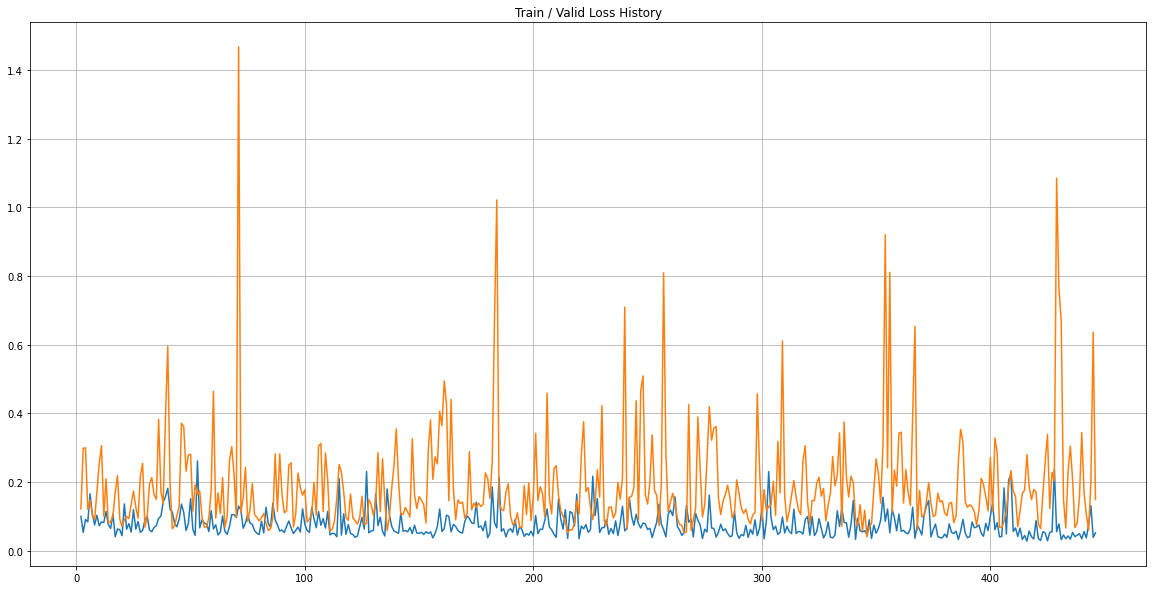

In [24]:
plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(2, len(train_history)), train_history[2:],
    range(2, len(valid_history)), valid_history[2:],
)

plt.show()

In [25]:
test_loss = 0
y_hat =[]

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_pred = model(x)
        loss = F.binary_cross_entropy(y_pred, y)
        
        test_loss = loss
        y_hat += [y_pred]
test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)
print("Test loss: %.4e" % test_loss)

Test loss: 3.9576e-02


In [31]:
correct = (y_test == (y_hat>.5)).sum()
total = float(y_test.size(0))
print("Test Accuracy", np.round(float(correct/total),5))

Test Accuracy 0.96512
